##Machine Translation Using a Seq2Seq Architecture

---
The goal of this colab is to get you more familiar with the Seq2Seq models and their challenges. For this reason, you will be working on machine translation problem where we would have a sentence as input (in english), and the output is gonna be the translated sentence (in french). So just like what happens with Google Translate.


**Just to give you a heads up:** We won't be having a model performing like Google translate, but at least we will have an idea about how Google Translate works and the challenges that exist with a translation problem.  

## Importing Libraries

We start by importing numpy and pandas and then we can add the rest

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
import pandas as pd
nltk.download('punkt')
nltk.download('punkt_tab')
import matplotlib.pyplot as plt
import string
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torch.nn.utils.rnn import pack_padded_sequence
import random

[nltk_data] Downloading package punkt to /home/mnl/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/mnl/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Upload your data here. Here is the [Drive link](https://drive.google.com/drive/folders/10ncj3w7kI9GPx_rz-WfKEGCv4Dz1EYf6?usp=sharing)

## Getting the data

In [3]:
en = pd.read_csv('Datasets/en.csv')
fr = pd.read_csv('Datasets/fr.csv')
english_sentences = en.iloc[:, 0]
french_sentences = fr.iloc[:, 0]

**How many sentences does each of the files contain?**

In [4]:
len(english_sentences), len(french_sentences)

(137859, 137859)

Now let us concatenate the 2 dataframes into one dataframe that we call **df** where one column has the english senetnces and the other has the french sentences

In [5]:
en.columns = ['English']
fr.columns = ['French']
combined_df = pd.concat([en, fr], axis=1)
print(combined_df.head())

                                             English  \
0  the united states is usually chilly during jul...   
1  california is usually quiet during march , and...   
2  the united states is sometimes mild during jun...   
3  your least liked fruit is the grape , but my l...   
4  his favorite fruit is the orange , but my favo...   

                                              French  
0  les états-unis est généralement froid en juill...  
1  california est généralement calme en mars , et...  
2  les états-unis est parfois légère en juin , et...  
3  votre moins aimé fruit est le raisin , mais mo...  
4  son fruit préféré est l'orange , mais mon préf...  


Pick a sentence and print it in both languages

In [6]:
print(combined_df.iloc[0, 0])
print(combined_df.iloc[0, 1])

the united states is usually chilly during july , and it is usually freezing in november .
les états-unis est généralement froid en juillet , et il gèle habituellement en novembre .


##Cleaning Data

The data that we have is almost clean as we can see, we just need to remove the punctuations inside of it.

In [7]:
'''remove the punctuation'''
combined_df['English'] = combined_df['English'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
combined_df['French'] = combined_df['French'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

''' convert to lowercase'''
combined_df['English'] = combined_df['English'].apply(lambda x: x.lower())
combined_df['French'] = combined_df['French'].apply(lambda x: x.lower())

Make sure that the punctuation is removed by printing the example that you printed earlier.

In [8]:
combined_df.iloc[0, 0], combined_df.iloc[0, 1]

('the united states is usually chilly during july  and it is usually freezing in november ',
 'les étatsunis est généralement froid en juillet  et il gèle habituellement en novembre ')

##Exploring the Data

Add a column **ENG Length** to the dataset that shows how many words does a sentence contain, and do the same for french in a column called **FR Length**

In [9]:
# add a column to the dataframe called "ENG Length" and "FR Length" that contains the length of the English and French sentences respectively
combined_df['ENG Length'] = combined_df['English'].apply(lambda x: len(x.split()))
combined_df['FR Length'] = combined_df['French'].apply(lambda x: len(x.split()))

print(combined_df.head())


                                             English  \
0  the united states is usually chilly during jul...   
1  california is usually quiet during march  and ...   
2  the united states is sometimes mild during jun...   
3  your least liked fruit is the grape  but my le...   
4  his favorite fruit is the orange  but my favor...   

                                              French  ENG Length  FR Length  
0  les étatsunis est généralement froid en juille...          15         13  
1  california est généralement calme en mars  et ...          13         13  
2  les étatsunis est parfois légère en juin  et i...          14         13  
3  votre moins aimé fruit est le raisin  mais mon...          14         14  
4  son fruit préféré est lorange  mais mon préfér...          12         11  


Visualize the distribution of the lengths of english sentences and french sentences.

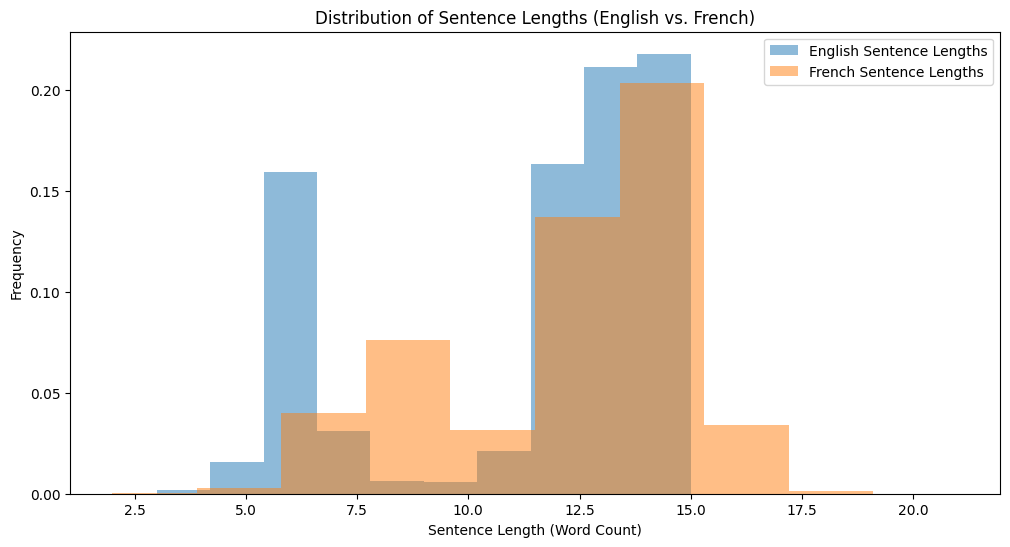

In [10]:
plt.figure(figsize=(12, 6))
plt.hist(combined_df['ENG Length'], bins=10, alpha=0.5, label='English Sentence Lengths',density=True) # density=True normalizes the data
plt.hist(combined_df['FR Length'], bins=10, alpha=0.5, label='French Sentence Lengths', density=True) # density=True normalizes the data (getting an approximation of the pdf)
plt.xlabel('Sentence Length (Word Count)')
plt.ylabel('Frequency')
plt.title('Distribution of Sentence Lengths (English vs. French)')
plt.legend()

plt.show()

Get the maximum length of an english sentence and the maximum length of a french sentence.

In [11]:
max_eng_length = combined_df['ENG Length'].max()
max_fr_length = combined_df['FR Length'].max()
max_eng_length, max_fr_length

(np.int64(15), np.int64(21))

##Preprocessing the Data

In order for the data to be fed to the model, it has to be tokenized and padded.

####Tokenization

**To tokenize english and french sentences, we can use only one tokenizer. True or False?**

Wrong, in this case I am using basic word tokenization through nltk.word_tokenize

Tokenize the sentences that we have.

In [12]:
def tokenize_sentences(sentences):
    return [word_tokenize(sentence.lower()) for sentence in sentences]
english_sentences = combined_df['English']
french_sentences = combined_df['French']
english_tokenized = tokenize_sentences(english_sentences)
french_tokenized = tokenize_sentences(french_sentences)
print(english_tokenized[0])
print(french_tokenized[0])
print(len(english_tokenized), len(french_tokenized))

['the', 'united', 'states', 'is', 'usually', 'chilly', 'during', 'july', 'and', 'it', 'is', 'usually', 'freezing', 'in', 'november']
['les', 'étatsunis', 'est', 'généralement', 'froid', 'en', 'juillet', 'et', 'il', 'gèle', 'habituellement', 'en', 'novembre']
137859 137859


**How many unique words do we have in english and in french?**

In [13]:
def build_vocabulary(tokenized_sentences, special_tokens=["<PAD>", "<SOS>", "<EOS>", "<UNK>"]):
    all_tokens_list = []
    for sentence in tokenized_sentences:
        all_tokens_list.extend(sentence)
    vocab = {token: idx for idx, token in enumerate(special_tokens)}
    for token in all_tokens_list:
        if token not in vocab:
            vocab[token] = len(vocab) # updating each token with a unique index, since len(vocab) is changing each time
    # Decoding Later 
    index_to_token = {idx: token for token, idx in vocab.items()}
    return vocab, index_to_token
english_vocab, english_index_to_token = build_vocabulary(english_tokenized)
french_vocab, french_index_to_token = build_vocabulary(french_tokenized)

print("English Vocabulary Size:", len(english_vocab))
print("French Vocabulary Size:", len(french_vocab))
print(english_vocab)

English Vocabulary Size: 203
French Vocabulary Size: 348
{'<PAD>': 0, '<SOS>': 1, '<EOS>': 2, '<UNK>': 3, 'the': 4, 'united': 5, 'states': 6, 'is': 7, 'usually': 8, 'chilly': 9, 'during': 10, 'july': 11, 'and': 12, 'it': 13, 'freezing': 14, 'in': 15, 'november': 16, 'california': 17, 'quiet': 18, 'march': 19, 'hot': 20, 'june': 21, 'sometimes': 22, 'mild': 23, 'cold': 24, 'september': 25, 'your': 26, 'least': 27, 'liked': 28, 'fruit': 29, 'grape': 30, 'but': 31, 'my': 32, 'apple': 33, 'his': 34, 'favorite': 35, 'orange': 36, 'paris': 37, 'relaxing': 38, 'december': 39, 'new': 40, 'jersey': 41, 'busy': 42, 'spring': 43, 'never': 44, 'our': 45, 'lemon': 46, 'january': 47, 'warm': 48, 'lime': 49, 'her': 50, 'banana': 51, 'he': 52, 'saw': 53, 'a': 54, 'old': 55, 'yellow': 56, 'truck': 57, 'india': 58, 'rainy': 59, 'that': 60, 'cat': 61, 'was': 62, 'most': 63, 'loved': 64, 'animal': 65, 'dislikes': 66, 'grapefruit': 67, 'limes': 68, 'lemons': 69, 'february': 70, 'china': 71, 'pleasant': 72,

####Padding

**What should be the length of the sequences that we have after padding?**

As the padding length, in this case I will take as the length of the maximum phrase here!!!

Perform padding on the sequences that we have.

In [14]:
def convert_to_sequence(tokenized_sentences, vocab, max_length):
    '''
    params: tokenized_sentences: List of sentences, each sentence is a list of tokens
            vocab: Dictionary containing the vocabulary where the keys are the tokens and the values are the indices
            max_length: Maximum length of the sequence
    return: List of sequences where each sequence is a list of indices representing the tokens in the input sentences
    '''
    sequences = []
    for sentence in tokenized_sentences:
        sequence = [vocab["<SOS>"]]

        # Convert each token to its index in the vocabulary
        sequence += [vocab.get(token, vocab["<UNK>"]) for token in sentence]

        # Add <EOS> at the end of each sequence
        sequence.append(vocab["<EOS>"])
        if len(sequence) > max_length:

            sequence = sequence[:max_length] # truncate the sequence to the maximum length (this will be used for new phrases( which won't necessarlily have a length of at most max_length))

        sequence += [vocab["<PAD>"]] * (max_length - len(sequence)) # fill the rest with <PAD> tokens (which has index 0)
        sequences.append(sequence)
    return sequences
# Note here I chose to pad to the right
english_sequences = convert_to_sequence(english_tokenized, english_vocab,max_eng_length+5)
french_sequences = convert_to_sequence(french_tokenized, french_vocab, max_fr_length+5) # 1 to inclde <EOS> token
print("Sample English Sequence:", english_sequences[0])
print("Sample French Sequence:", french_sequences[0])

Sample English Sequence: [1, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 7, 8, 14, 15, 16, 2, 0, 0, 0]
Sample French Sequence: [1, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 9, 15, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


### Batching 

In [15]:
english_tensor = torch.tensor(english_sequences, dtype=torch.long)
french_tensor = torch.tensor(french_sequences, dtype=torch.long)

# Create a dataset and data loader for batching
dataset = TensorDataset(english_tensor, french_tensor)
batch_size = 32  # Example batch size
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

for english_batch, french_batch in dataloader:
    print("English Batch Shape:", english_batch.shape) # batch_size x max_length
    print("French Batch Shape:", french_batch.shape) # batch_size x max_length
    break  

English Batch Shape: torch.Size([32, 20])
French Batch Shape: torch.Size([32, 26])


##Modeling

After preprrocessing the data, we can build our model. Start by building a baseline architecture relying on one directional RNNs, LSTMs, or GRUs. It will be good to lookup how to build Seq2Seq models, there are some new layers that will help you like RepeatVector and TimeDistributed.

# Encoder

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, num_layers=2):
        '''
        input_dim: The size of the input vocabulary (It tells the model how many unique tokens it can expect to see)

        '''
        super(Encoder, self).__init__()

        self.embedding = nn.Embedding(input_dim, embedding_dim) # it will have a matrix of size (input_dim, embedding_dim)
        # where each row of the matrix will represent the embedding of a token in the vocabulary
        '''Now each token in my input sequence is an index that refers to a row in this embedding matrix.'''
        '''This lookup returns a new tensor of shape (batch_size, max_length, embedding_dim)'''
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True) # batch_first=True means that the first dimension of the input and output will be the batch size (batch_size, max_length, hidden_dim)
        # note that in LSTM, the time step happens under the hood
        # LSTM treats each position along sequence lenth as a time step
        
    def forward(self, src, src_lengths):
        # src shape: (batch_size, max_length) - a batch of sequences of token indices
        # src_lengths shape: (batch_size) - the actual lengths of each sequence without padding


        '''If src has shape (batch_size, max_length) (a batch of padded sequences of token indices), the embedding layer’s output will be a tensor of shape (batch_size, max_length, embedding_dim)'''
        embedded = self.embedding(src)  # shape: (batch_size, max_length, embedding_dim)
        

        '''LSTM will process only the non-padded elements'''
        packed_embedded = pack_padded_sequence(embedded, src_lengths, batch_first=True, enforce_sorted=False) # 
        packed_outputs, (hidden, cell) = self.lstm(packed_embedded)
        # hidden and cell shapes: (num_layers, batch_size, hidden_dim)
        
        # Note if you need the outputs you need to unpack the sequences using pad_packed_sequence
        # outputs, _ = pad_packed_sequence(packed_outputs, batch_first=True) #outputs shape: (batch_size, max_length, hidden_dim)
    
        return hidden, cell



'''Let's test the encoder with a batch of 10 sequences'''
actual_lengths = torch.tensor([len([token for token in sentence if token != english_vocab["<PAD>"]]) for sentence in english_tensor[:10]])

input_dim = len(english_vocab)  # Vocabulary size
embedding_dim = 256             # Embedding dimension
hidden_dim = 512                # Hidden dimension
num_layers = 2                  # Number of layers in the LSTM

# Initialize the encoder
encoder = Encoder(input_dim, embedding_dim, hidden_dim, num_layers)
# forward pass 
hidden, cell = encoder(english_tensor, actual_lengths)
print("Hidden State Shape:", hidden.shape)  # Expected: (num_layers, batch_size, hidden_dim)
print("Cell State Shape:", cell.shape)      # Expected: (num_layers, batch_size, hidden_dim)

assert hidden.shape == (num_layers, english_tensor[:10].size(0), hidden_dim), "Hidden state shape mismatch!"
assert cell.shape == (num_layers, english_tensor[:10].size(0), hidden_dim), "Cell state shape mismatch!"

print("Encoder output verification passed!")

Hidden State Shape: torch.Size([2, 10, 512])
Cell State Shape: torch.Size([2, 10, 512])
Encoder output verification passed!


# Decoder 

In [24]:
class Decoder(nn.Module):
    def __init__(self, output_dim, embedding_dim, hidden_dim, num_layers=2, teacher_forcing_ratio=0.5):
        super(Decoder, self).__init__()
        self.teacher_forcing_ratio = teacher_forcing_ratio

        # Embedding layer for the output vocabulary( French vocabulary)
        self.embedding = nn.Embedding(output_dim, embedding_dim)
    
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        
        # Fully connected layer to generate predictions over vocabulary
        self.fc_out = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, input_token, hidden, cell):
        # input_token shape: (batch_size) - single token for each sequence in the batch, since later in the full model we will be looping over the sequence length(1 token at a time)
        
        '''Step 1: Embed the input token'''
        embedded = self.embedding(input_token).unsqueeze(1)  # Shape: (batch_size, 1, embedding_dim)
        
        '''Step 2: Pass the embedded input through the LSTM'''
        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))  # Shape: (batch_size, 1, hidden_dim)
        
        '''Step 3: Generate prediction for the next token'''
        prediction = self.fc_out(output.squeeze(1))  # Shape: (batch_size, output_dim)
        
        return prediction, hidden, cell


# Full Model (Encoder + Decoder)

In [25]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder,  teacher_forcing_ratio=0.5):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.teacher_forcing_ratio = teacher_forcing_ratio
    def forward(self, src, src_lengths, tgt):
        # src: Source input sequence (English) - Shape: (batch_size, src_sequence_length)
        # src_lengths: Actual lengths of each sequence in src (ignores padding)
        # tgt: Target sequence (French) - Shape: (batch_size, tgt_sequence_length)
        
        batch_size = src.shape[0]
        tgt_sequence_length = tgt.shape[1]
        tgt_vocab_size = self.decoder.fc_out.out_features

        '''Decoder outputs tensor'''
        outputs = torch.zeros(batch_size, tgt_sequence_length, tgt_vocab_size) # output the full prob. distribution over the output vocabulary for each time step in the target sequence, for thecomputing the loss function, but in inference we will only use the argmax of this distribution

        '''Get the hidden and cell states from the encoder'''
        hidden, cell = self.encoder(src, src_lengths)

        '''The first input to the decoder is the <SOS> token for each sequence'''
        input_token = tgt[:, 0]  # Shape: (batch_size)

        '''Go over each token in the target sequence'''
        for t in range(1, tgt_sequence_length):
            '''Input token: is the current token that we’re feeding to the decoder'''
            output, hidden, cell = self.decoder(input_token, hidden, cell)
            
            # Store the output prediction for this time step
            outputs[:, t, :] = output
            
            '''Determine if we should use teacher forcing'''
            teacher_force = random.random() < self.teacher_forcing_ratio
            input_token = tgt[:, t] if teacher_force else output.argmax(1)

        return outputs
    def inference(self, src, src_lengths, max_len=23, start_token=1, end_token=2):
        # src: Source input sequence - Shape: (batch_size, src_sequence_length) (English)
        # src_lengths: Actual lengths of each sequence in src (ignores padding)
        # max_len: Maximum length of the generated sequence 
        # start_token: Start-of-sequence token index
        # end_token: End-of-sequence token index
        
        batch_size = src.shape[0]

        '''Encode the source sequence'''
        hidden, cell = self.encoder(src, src_lengths)

        '''Initialize the input token with the <SOS> token, for each sequence in the batch'''
        input_token = torch.tensor([start_token] * batch_size) # Shape: (batch_size)

        generated_tokens = torch.zeros(batch_size, max_len).long() # storing the token indices

        for t in range(max_len):
            output, hidden, cell = self.decoder(input_token, hidden, cell)
            
            '''Get the most likely token (predicted token) at this time step'''
            input_token = output.argmax(1)  # Shape: (batch_size)
            generated_tokens[:, t] = input_token
            
            '''Stop generating if all sequences in the batch reach <EOS>'''
            if (input_token == end_token).all():
                break
        return generated_tokens


Compile and train the model.
**FYI:** While specifying the architecture of your model and the number of epochs for training, keeep in your mind that your model might take A LOT of time to train.

# Data taking care f the train_loader 

In [26]:
class TranslationDataset(Dataset):
    def __init__(self, src_sentences, tgt_sentences, src_vocab, tgt_vocab, max_src_len, max_tgt_len):
        self.src_sentences = src_sentences
        self.tgt_sentences = tgt_sentences
        self.src_vocab = src_vocab
        self.tgt_vocab = tgt_vocab
        self.max_src_len = max_src_len
        self.max_tgt_len = max_tgt_len
    
    def __len__(self):
        return len(self.src_sentences)
    
    def __getitem__(self, idx):
        # Get source and target sentences
        src_sentence = self.src_sentences[idx]
        tgt_sentence = self.tgt_sentences[idx]
        
        # Convert tokens to indices and pad to max length
        src_indices = self._convert_and_pad(src_sentence, self.src_vocab, self.max_src_len, "<PAD>")
        tgt_indices = self._convert_and_pad(tgt_sentence, self.tgt_vocab, self.max_tgt_len, "<PAD>")

        # Get actual lengths (ignoring <PAD> tokens)
        src_length = min(len(src_sentence), self.max_src_len)
        tgt_length = min(len(tgt_sentence), self.max_tgt_len)

        return torch.tensor(src_indices), src_length, torch.tensor(tgt_indices)
    
    def _convert_and_pad(self, sentence, vocab, max_len, pad_token):
        # Convert tokens to indices
        indices = [vocab.get(token, vocab["<UNK>"]) for token in sentence]
        # Truncate if necessary and pad to max length
        indices = indices[:max_len] + [vocab[pad_token]] * (max_len - len(indices))
        return indices


max_src_len = 25  
max_tgt_len = 25  
batch_size = 32   # Batch size

# Initialize the dataset
train_dataset = TranslationDataset(
    src_sentences=english_tokenized, 
    tgt_sentences=french_tokenized, 
    src_vocab=english_vocab, 
    tgt_vocab=french_vocab, 
    max_src_len=max_src_len, 
    max_tgt_len=max_tgt_len
)
def collate_batch(batch, max_src_len, max_tgt_len):
    src_batch, src_lengths, tgt_batch = zip(*batch)
    
    # Stack each element of the batch to create the batch tensors
    src_batch = torch.stack(src_batch)
    tgt_batch = torch.stack(tgt_batch)
    src_lengths = torch.tensor(src_lengths)

    return src_batch, src_lengths, tgt_batch

# Initialize the DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: collate_batch(x, max_src_len, max_tgt_len))


In [27]:
# Hyperparameters
input_dim = len(english_vocab)
output_dim = len(french_vocab)
embedding_dim = 256
hidden_dim = 512
num_layers = 2
learning_rate = 0.001
teacher_forcing_ratio = 0.5
num_epochs = 10

# Initialize the encoder, decoder, and Seq2Seq model
encoder = Encoder(input_dim, embedding_dim, hidden_dim, num_layers)
decoder = Decoder(output_dim, embedding_dim, hidden_dim, num_layers, teacher_forcing_ratio=teacher_forcing_ratio)
model = Seq2Seq(encoder, decoder)

# Optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss(ignore_index=french_vocab["<PAD>"])

# Training loop
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    
    for src, src_lengths, tgt in train_dataloader:  # Assume train_dataloader yields batches of data
        src, src_lengths, tgt = src, src_lengths, tgt
        
        optimizer.zero_grad()
        
        # Forward pass through the Seq2Seq model
        output = model(src, src_lengths, tgt)  # Shape: (batch_size, tgt_sequence_length, output_dim)
        
        # Reshape output and target for calculating loss
        output = output[:, 1:].reshape(-1, output_dim)  # Remove the first timestep (<SOS>)
        tgt = tgt[:, 1:].reshape(-1)  # Align target sequence to ignore <SOS>

        # Calculate loss
        loss = criterion(output, tgt)
        
        # Backpropagation and optimization
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss / len(train_dataloader)}")


KeyboardInterrupt: 

Define a function that gets an input sentence in english and gives the output sentence in the french language.

In [ ]:
#Test Your Knowledge

Test the following sentence

In [ ]:
input = "she is driving the truck"

#Test Your Knowledge

Try to improve your model by modifying the architecture to take into account bidirectionality which is very useful in Machine Translation. Create a new model called model2

In [ ]:
#Test Your Knowledge

compile and train your new model.

In [ ]:
#Test Your Knowledge

Define a new function that relies on your new model to make predictions.

In [ ]:
#Test Your Knowledge

In [ ]:
input = "she is driving the truck"

#Test Your Knowledge

**What is another adjustment in terms of architecture that you might be able to do to improve your model?**

[Share Your Knowledge]

**What are some additional ways that we can do to improve the performance of our model?**

[Share Your Knowledge]

# Video Recording Link

**A short (10 minutes max) recorded video where you explain your solution.
Make sure your face is visible in the video, as if you’re presenting your
work during a job interview.**

[Share The Link Here]